#  RCA II on simulated data
---

This notebook presents an example of the use of RCA II to model the PSF from simulated data.

## Contents
1. [Data preparation](#1-DATA-PREPARATION)
    1. [Load simulated data](#Load-simulated-data)
    1. [Split data](#SPLIT-DATA)
1. [RCA II](#2-RCA$^{++}$)
    1. [Fit model](#FIT-MODEL)
    1. [PSF estimation](#PSF-Estimation)
    1. [EigenPSFs](#EigenPSFs)
    1. [Few examples](#Few-examples)
---

In [1]:
import numpy as np
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import rca

Define a function for visual inspection:

In [2]:
def plot_func(im, cmap='gist_stern', title=''):
    plt.imshow(im, cmap=cmap, interpolation='Nearest')
    plt.title(title)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.show()
    plt.close()

---
## 1 Data preparation

### Load simulated data

Load data; `RCADECONV_data.fits` is splitted into 2 hdu, the first one contains 625 simulated observed stars and their positions and the second one contains 625 simulated observed galaxies and their positions.`RCADECONV_groundtruth.fits` is also splitted into 2 hdu, the first one contains 625 simulated PSFs and their positions and the second one contains 625 simulated true galaxies and their positions.
All the data are simulated at the same positions.

In [3]:
hdulist1 = fits.open('RCADECONV_data.fits')
hdulist2 = fits.open('RCADECONV_groundtruth.fits')

In [4]:
hdu1_1 = hdulist1[0]
hdu1_2 = hdulist1[1]
hdu2_1 = hdulist2[0]
hdu2_2 = hdulist2[1]

For each hdu, retrieve the data and their related positons in arrays:

In [5]:
def separate(hdu):
    obs, obs_pos = [], []
    for m in range(25):
        for n in range(25):
            obs.append([[hdu.data[51*m+i][51*n+j] for i in range(51)] for j in range(51)])
            obs_pos.append([51*m+12, 51*n+12])
    return np.array(obs), np.array(obs_pos)

In [6]:
galaxies, galaxies_pos = separate(hdu1_1)
stars, stars_pos = separate(hdu1_2)
galaxies_truth, _ = separate(hdu2_1)
PSFs_truth, _ = separate(hdu2_2)

### Split data

Split them into stars and 'train' and 'test' galaxies:

In [7]:
gal_idx = np.random.choice(galaxies.shape[0], 156 , False)
star_idx = np.random.choice(list(set(range(galaxies.shape[0])) - set(gal_idx)),313,False)
test_idx = list(set(range(galaxies.shape[0])) - set(gal_idx)- set(star_idx))

In [8]:
train_galaxies, train_galaxies_pos = galaxies[gal_idx], galaxies_pos[gal_idx]
test_galaxies, test_galaxies_pos = galaxies[test_idx], galaxies_pos[test_idx]
stars, stars_pos = stars[star_idx], stars_pos[star_idx]

Retrieve the ground truth PSFs at the positions of the 'test' galaxies set to compare the PSFs estimate model:

In [9]:
test_PSFs_truth = PSFs_truth[test_idx]

---
## 2 RCA II

### Fit model

RCA II needs stars and galaxies to be respectively in $(p\times p\times n_\rm{stars})$ and $(p\times p\times n_\rm{galaxies})$ format:

In [10]:
stars = rca.utils.rca_format(stars)
train_galaxies = rca.utils.rca_format(train_galaxies)

RCA II expects at least one parameter: `n_comp` is the number of eigenPSFs.

In [11]:
n_comp = 4

In [12]:
rca_runner = rca.RCA(n_comp)

In [ ]:
S, A = rca_runner.fit(stars, train_galaxies, stars_pos, train_galaxies_pos)

In [14]:
rca_runner.quicksave('simulated_data_fitted_model')

### PSF estimation

To compare estimate PSFs with true PSFs, we need their shifts:

In [15]:
cents = []
for psf in test_PSFs_truth:
    cents += [rca.utils.CentroidEstimator(psf)]
test_shifts = np.array([ce.return_shifts() for ce in cents])

Estimate PSF all the positions. `shifts` are set to get PSFs estimate sampled on the right grid for comparisons with true PSFs.

In [16]:
test_PSFs_estimate = rca_runner.estimate_psf(test_galaxies_pos, apply_degradation=True, shifts=test_shifts)

Normalize all the PSFs for comparisons:

In [17]:
for j in range(test_PSFs_estimate.shape[0]):
    test_PSFs_estimate[j] /= test_PSFs_estimate[j].sum()
    test_PSFs_truth[j] /= test_PSFs_truth[j].sum()

### EigenPSFs

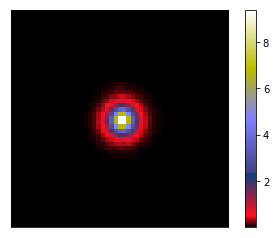

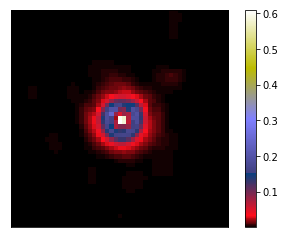

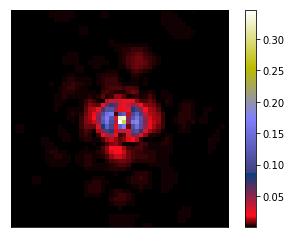

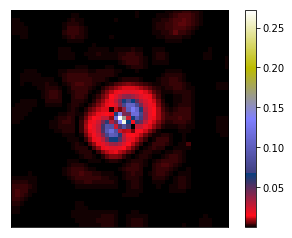

In [18]:
eigenPSFs = rca.utils.reg_format(S)
for epsf in eigenPSFs:
    plot_func(abs(epsf))

### Few examples

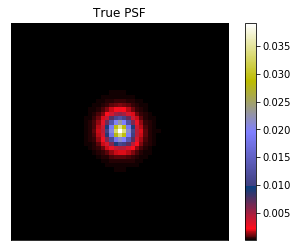

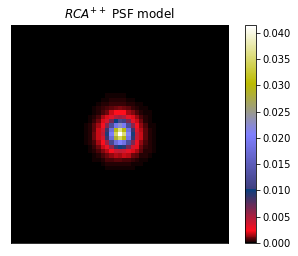

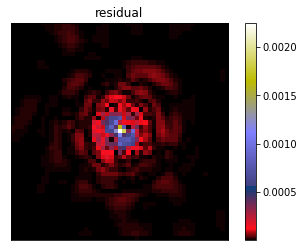

7


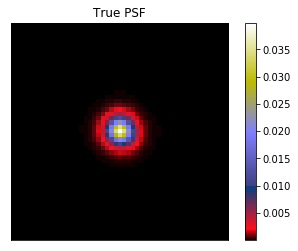

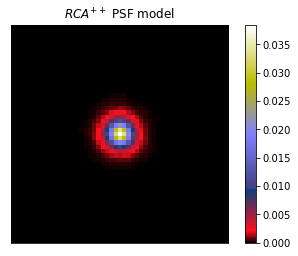

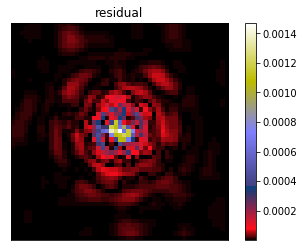

67


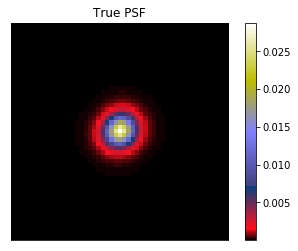

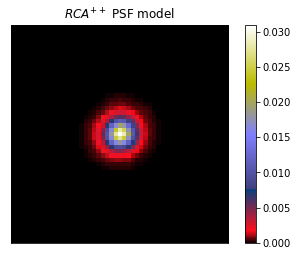

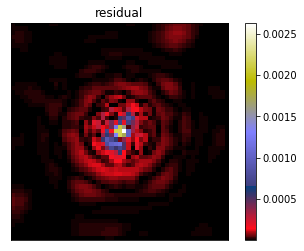

21


In [19]:
for j in np.random.choice(test_galaxies.shape[0], 3, False):
    true_psf = test_PSFs_truth[j]
    plot_func(true_psf, title='True PSF')
    est_psf = test_PSFs_estimate[j]
    plot_func(est_psf, title=r'$RCA^{++}$ PSF model')
    plot_func(np.abs(true_psf-est_psf), title='residual')
    print j